In [24]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import pandas as pd
from scipy import stats
import math

In [25]:
def get_exps_data(base_path):
    exp_dir_path = base_path
    exp_data = {
        'Title': [],
        'Margin S': [],
        'Margin D': [],
        'Losses': [],
        'Mean Losses': [],
        'Hedged Scores': [],
        'True Scores': []
    }
    # Adapted from:
    # https://stackoverflow.com/a/3925147
    exp_dir = os.path.basename(os.path.normpath(exp_dir_path))
    if os.path.isdir(exp_dir_path):
        params_path = os.path.join(exp_dir_path, 'hyperparameters.json')
        assert os.path.exists(params_path)
        with open(params_path, 'r') as f:
            params = json.loads(f.read())
        exp_data['Title']\
            .append(f"margin_s: {params['margin_s']:<04},"
                    f"margin_d: {params['margin_d']:<04},")
        exp_data['Margin S'].append(params['margin_s'])
        exp_data['Margin D'].append(params['margin_d'])
        losses_path = os.path.join(exp_dir_path,
                                   f"{exp_dir}_raw_losses.npy")
        assert os.path.exists(losses_path)
        losses = np.load(losses_path)
        exp_data['Losses'].append(losses)
        exp_data['Mean Losses'].append(np.mean(losses, axis=0))
        hedged_scores_path = os.path.join(exp_dir_path,
                                          f"{exp_dir}"
                                          "_all_eval_hedged_scores.csv")
        assert os.path.exists(hedged_scores_path)
        hedged_scores = pd.read_csv(hedged_scores_path,
                                    index_col=None)
        hedged_overall = hedged_scores['overall'].iloc[-1]
        hedged_sub_overall = hedged_scores['sub_overall'].iloc[-1]
        exp_data['Hedged Scores'].append((hedged_overall,
                                          hedged_sub_overall))

        true_scores_path = os.path.join(exp_dir_path,
                                        f"{exp_dir}"
                                        "_all_eval_true_scores.csv")
        assert os.path.exists(true_scores_path)
        true_scores = pd.read_csv(true_scores_path,
                                  index_col=None)
        true_overall = true_scores['overall'].iloc[-1]
        true_sub_overall = true_scores['overall'].iloc[-1]
        exp_data['True Scores'].append((true_overall,
                                        true_sub_overall))
    return exp_data

In [42]:
def plot_fit_line(fraction, batch_numbers, losses, color):
    split_point = len(batch_numbers) - round(len(batch_numbers) * fraction)
    x = batch_numbers[split_point:]
    y = losses[split_point:]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))

    x_fit = np.linspace(split_point, max(batch_numbers), 100)
    y_fit = np.exp(slope * x_fit + intercept)

    if fraction == 1.0:
        label = f"Full run Trend (slope={slope:.2e})"
    else:
        label = f"Final {fraction:.1f} Trend (slope={slope:.2e})"

    plt.plot(x_fit, y_fit, '--', color=color, label=label, linewidth=1.5)

In [43]:
base_path = "/Users/zacbolton/dev/BSc/FP/historical_av_with_SBERT/saved_experiments/valla_validation_undistorted_long"
exps_data = get_exps_data(base_path)

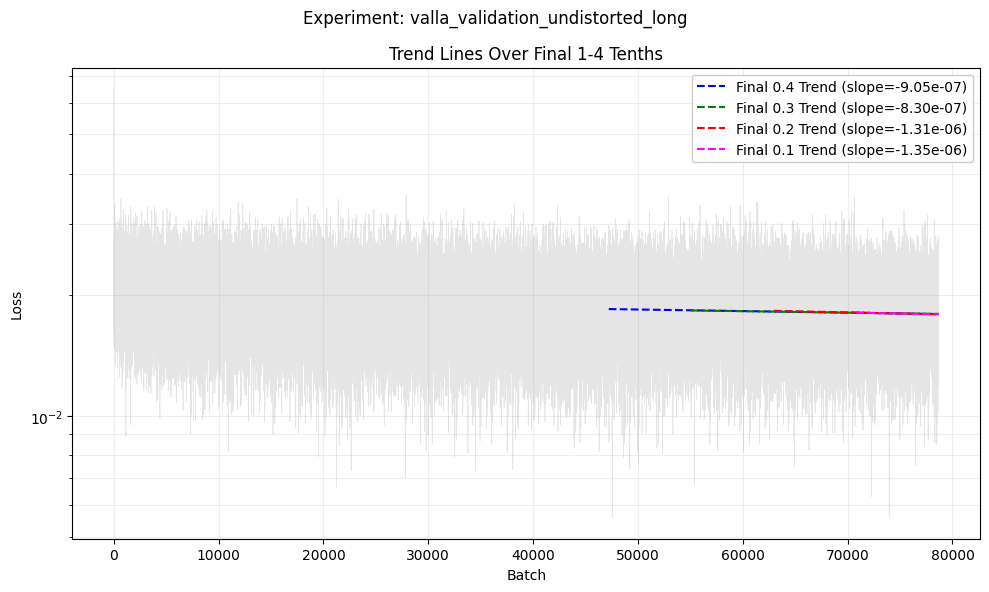

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))

losses = np.array(exps_data['Losses'][0])
if losses.ndim > 1:
    losses = losses.flatten()
batch_numbers = np.arange(len(losses))

ax.plot(batch_numbers, losses, color='gray', alpha=0.2,
        linewidth=0.5)

plt.grid(True)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.suptitle("Experiment: valla_validation_undistorted_long")
plt.title('Trend Lines Over Final 1-4 Tenths')

plt.yscale('log')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(True, which="both", ls="-", alpha=0.2)

colors = ['blue', 'green', 'red', 'magenta']
plot_fit_line(0.4, batch_numbers, losses, colors[0])
plot_fit_line(0.3, batch_numbers, losses, colors[1])
plot_fit_line(0.2, batch_numbers, losses, colors[2])
plot_fit_line(0.1, batch_numbers, losses, colors[3])

plt.legend(loc='upper right', framealpha=1.0)

plt.tight_layout()
plt.show()

In [50]:
score_data = {}
targ_cols = [
    'Title',
    'Margin S',
    'Margin D',
    'Hedged Scores',
    'True Scores'
]
val_data = {
    'Title': [],
    'Margin S': [],
    'Margin D': [],
    'Hedged Scores (overall)': [],
    'Hedged Scores (sub_overall)': [],
    'True Scores (overall)': [],
    'True Scores (sub_overall)': []
}
for k in exps_data:
    if k in targ_cols:
        if k.endswith(' Scores'):
            if k.startswith('Hedged '):
                val_data['Hedged Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['Hedged Scores (sub_overall)'] = [j for i, j in exps_data[k]]
            elif k.startswith('True '):
                val_data['True Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['True Scores (sub_overall)'] = [j for i, j in exps_data[k]]
        else:
            val_data[k] = exps_data[k]

df_exp_data = pd.DataFrame(val_data)

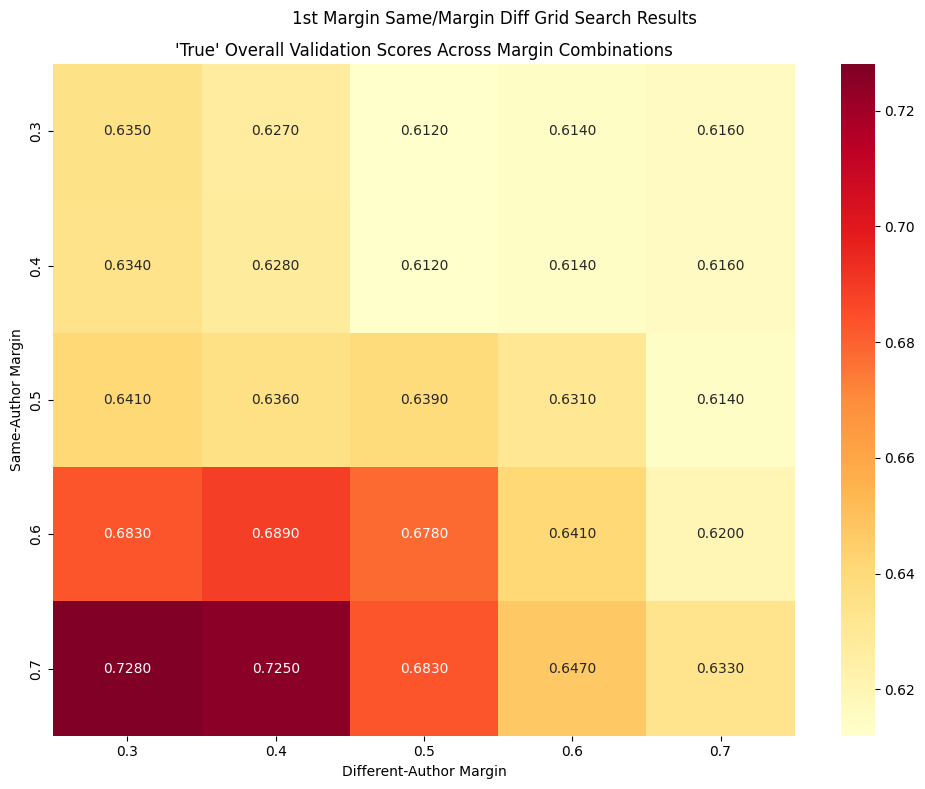


Pivot Table Structure:
Margin D    0.3    0.4    0.5    0.6    0.7
Margin S                                   
0.3       0.635  0.627  0.612  0.614  0.616
0.4       0.634  0.628  0.612  0.614  0.616
0.5       0.641  0.636  0.639  0.631  0.614
0.6       0.683  0.689  0.678  0.641  0.620
0.7       0.728  0.725  0.683  0.647  0.633


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_exp_data.pivot_table(
    values='True Scores (overall)',
    index='Margin S',
    columns='Margin D'
)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(pivot,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd',
            ax=ax)

plt.xlabel('Different-Author Margin')
plt.ylabel('Same-Author Margin')

plt.suptitle("1st Margin Same/Margin Diff Grid Search Results")
plt.title("'True' Overall Validation Scores Across Margin Combinations")

plt.tight_layout()
plt.show()

print("\nPivot Table Structure:")
print(pivot)